# Transfer Learningのお勉強

*20170621 Mitsuhiro Ito*

自分で書いてみよう！  
目標　高精度な犬猫を分類するモデルの構築

* [keras公式ブログ](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)
* [keras公式ドキュメント](https://keras.io/applications)
* [@aidiaryさんの記事](http://aidiary.hatenablog.com/entry/20170110/1484057655)

---

# 1. 前準備

In [35]:
from __future__ import print_function, division
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [36]:
import sys
from utils import save_model_viz, save_weights, save_hist, plot_hist
from utils import load_mnist_3D

# 2. 画像ファイルの入手


犬猫データはKaggleからゲットしました  
登録がめんどくさいです  
https://www.kaggle.com/c/dogs-vs-cats/data


次に画像ファイルをtrain用1000枚、validation用400枚に分けます

In [3]:
import os

In [ ]:
source_dir = "/Users/mitsuhiro/Work/train"　#画像ファイルへのpath

In [ ]:
os.makedirs("%s/data" % "/Users/mitsuhiro/Work")　#train、valid用のフォルダを順次作成
data_dir = "/Users/mitsuhiro/Work/data"

In [ ]:
os.makedirs("%s/train" % data_dir)
os.makedirs("%s/valid" % data_dir)
train_dir = "/Users/mitsuhiro/Work/data/train"
valid_dir = "/Users/mitsuhiro/Work/data/valid"

In [ ]:
os.makedirs("%s/dogs" % train_dir)
os.makedirs("%s/cats" % train_dir)
os.makedirs("%s/dogs" % valid_dir)
os.makedirs("%s/cats" % valid_dir)

In [ ]:
for i in range(1000):　#train用画像ファイルを移動
    os.rename("%s/dog.%d.jpg" % (source_dir, i + 1),
              "%s/dogs/dog%04d.jpg" % (train_dir, i + 1))
    os.rename("%s/cat.%d.jpg" % (source_dir, i + 1),
              "%s/cats/cat%04d.jpg" % (train_dir, i + 1))

In [ ]:
ls "/Users/mitsuhiro/Work/data/train/cats"

In [ ]:
for i in range(400):#valid用画像ファイルを移動
    os.rename("%s/dog.%d.jpg" % (source_dir, 1000 + i + 1),
              "%s/dogs/dog%04d.jpg" % (valid_dir, i + 1))
    os.rename("%s/cat.%d.jpg" % (source_dir, 1000 + i + 1),
              "%s/cats/cat%04d.jpg" % (valid_dir, i + 1))


こんな感じになりました

    data/
        train/
              dogs/
                  dog.0001.jpg  ...  dog.1000.jpg
              cats/
                  cat.0001.jpg  ...  cat.1000.jp
                
        valid/
              dogs/
                  dog.0001.jpg  ...  dog.0400.jpg
              cats/
                　cat.0001.jpg  ...  cat.0400.jpg
                
---

# 3. 画像データへ加工

In [7]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [8]:
generator = ImageDataGenerator(rescale=1.0 / 255) 

ImageDataGeneratorによりリアルタイムに，画像データを生成する  
引数にはいろいろあるがrescaleなしで4-1.のCNNをやった場合、val_actが0.5付近から全然増えない...

ImageDataGenerator参考
https://keras.io/ja/preprocessing/image/


In [9]:
train_generator = generator.flow_from_directory('data/train/',
        target_size=(150, 150),
        batch_size=16,
        class_mode='binary',
        shuffle=False)
valid_generator = generator.flow_from_directory('data/valid/',
        target_size=(150, 150),
        batch_size=16,
        class_mode='binary',
        shuffle=False)

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


このgeneratorに渡せばデータ化してくれる

---




# 4.1 モデル構築＆評価　CNN

In [25]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

In [26]:
train_generator = generator.flow_from_directory('data/train/',
        target_size=(150, 150),
        batch_size=16,
        class_mode='binary')
valid_generator = generator.flow_from_directory('data/valid/',
        target_size=(150, 150),
        batch_size=16,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [27]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [28]:
RUN_ID = 'CNN'
save_model_viz(RUN_ID, model)

In [29]:
batch_size = 16
hist = model.fit_generator(train_generator, 
                    steps_per_epoch = 2000 // batch_size, 
                    epochs=20, 
                    verbose=1, 
                    validation_data = valid_generator,
                    validation_steps= 800 // batch_size)

save_weights(RUN_ID, model)
save_hist(RUN_ID, hist)

Epoch 1/20
125/125 [==============================] - 6s - loss: 0.6948 - acc: 0.5325 - val_loss: 0.6853 - val_acc: 0.6200

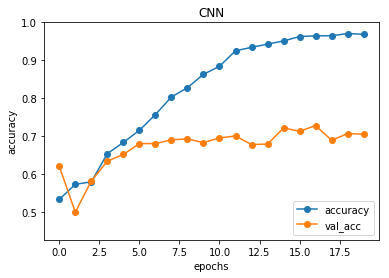

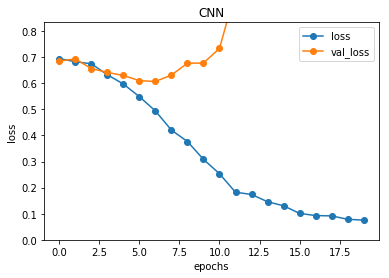

In [30]:
plot_hist(RUN_ID)

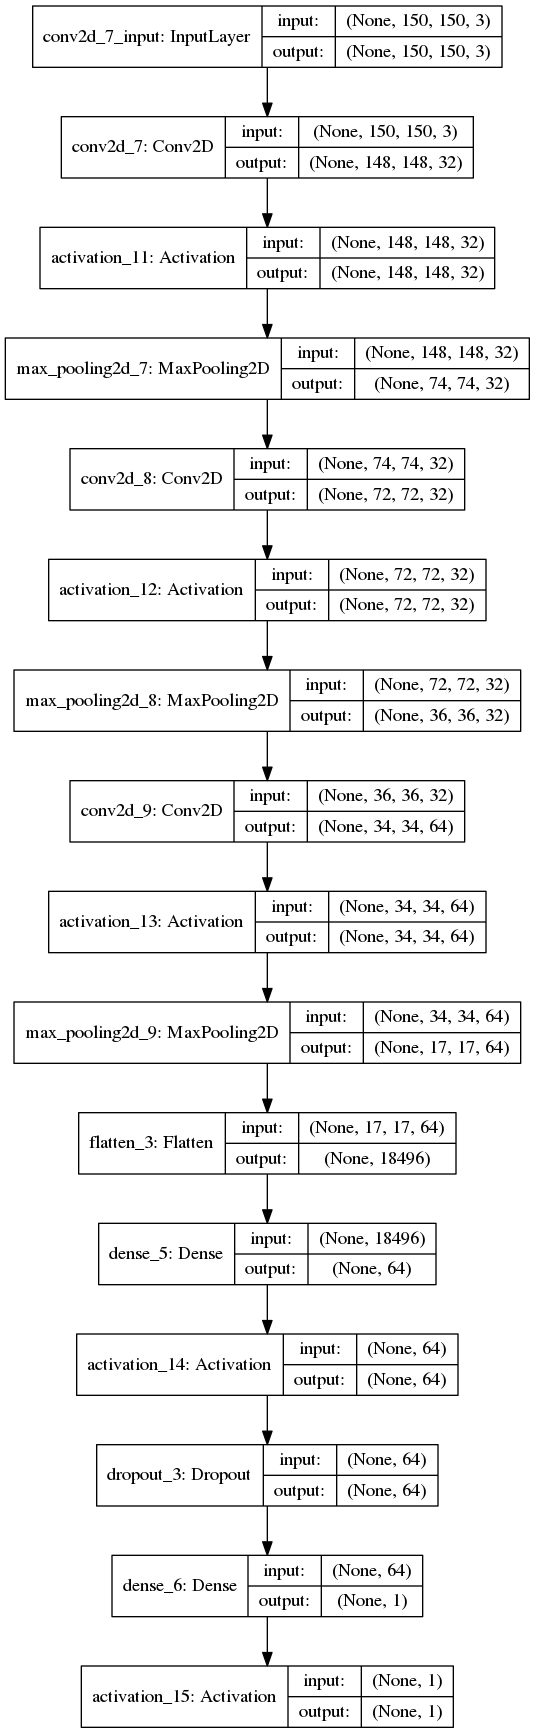

In [31]:
from IPython.display import Image
Image("model/CNN_vis.png", width=200)

---

# 4.2 モデル構築＆評価　VGG16を特長抽出機として使用

---

まずはVGG16を使って特徴量を抽出して保存

In [53]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

In [54]:
train_generator = generator.flow_from_directory('data/train/',
        target_size=(150, 150),
        batch_size=16,
        class_mode=None,
        shuffle=False)
valid_generator = generator.flow_from_directory('data/valid/',
        target_size=(150, 150),
        batch_size=16,
        class_mode=None,
        shuffle=False)

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [55]:
from keras.applications.vgg16 import VGG16

In [56]:
model = VGG16(include_top=False, weights='imagenet') # include_top=Fals :VGG16のFC部分を削除

In [57]:
batch_size = 16
bottleneck_features_train = model.predict_generator(train_generator, 2000 // batch_size, verbose = 1)

125/125 [==============================] - 5s      

In [58]:
print(bottleneck_features_train.shape)

(2000, 4, 4, 512)


In [59]:
np.save(open('bottleneck_features_train.npy', 'wb'), bottleneck_features_train)

In [60]:
batch_size = 16
bottleneck_features_valid = model.predict_generator(valid_generator, 800 // batch_size , verbose = 1)

50/50 [==============================] - 1s     

In [61]:
np.save(open('bottleneck_features_valid.npy', 'wb'), bottleneck_features_valid)

---

次に抽出した特徴量をinputとするFC層を作る

In [62]:
train_data = np.load(open('bottleneck_features_train.npy', 'rb'))
train_labels = np.array([0] * 1000 + [1] * 1000)

In [63]:
valid_data = np.load(open('bottleneck_features_valid.npy','rb'))
valid_labels = np.array([0] * 400 + [1] * 400)

In [64]:
print(train_data.shape)
print(valid_data.shape)

(2000, 4, 4, 512)
(800, 4, 4, 512)


In [65]:
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [66]:
RUN_ID = 'Feature_FC'
save_model_viz(RUN_ID, model)

In [67]:
hist = model.fit(train_data, train_labels,
          epochs=20,
          batch_size=batch_size,
          validation_data=(valid_data, valid_labels))

save_weights(RUN_ID, model)
save_hist(RUN_ID, hist)

Train on 2000 samples, validate on 800 samples
Epoch 1/20
2000/2000 [==============================] - 0s - loss: 0.6848 - acc: 0.7625 - val_loss: 0.4021 - val_acc: 0.8150

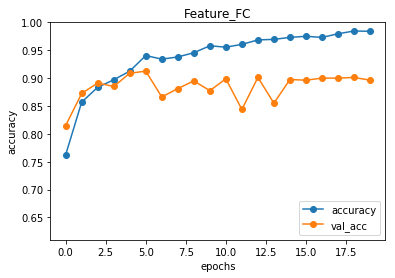

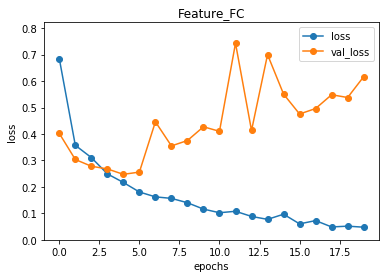

In [68]:
plot_hist(RUN_ID)

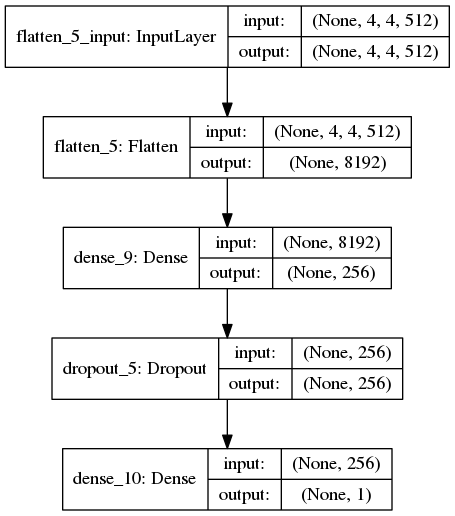

In [69]:
from IPython.display import Image
Image("model/Feature-FC_vis.png", width=200)


# 4.3 モデル構築＆評価　VGG16によるFine tuning



In [40]:
from keras import applications
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import Activation, Dropout, Flatten
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [41]:
generator = ImageDataGenerator(rescale=1.0 / 255) 

In [42]:
train_generator = generator.flow_from_directory('data/train/',
        target_size=(150, 150),
        batch_size=16,
        class_mode='binary',
        shuffle=False)
valid_generator = generator.flow_from_directory('data/valid/',
        target_size=(150, 150),
        batch_size=16,
        class_mode='binary',
        shuffle=False)

Found 2000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [43]:
input_tensor = Input(shape=(150,150,3))
vgg_model = applications.VGG16(weights='imagenet', input_tensor=input_tensor, include_top=False)

In [44]:
top_model = Sequential()
top_model.add(Flatten(input_shape=vgg_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

In [45]:
model = Model(input=vgg_model.input, output=top_model(vgg_model.output))

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("se..., inputs=Tensor("in...)`
  if __name__ == '__main__':


model.add(top_model)は使えない

In [46]:
for layer in model.layers[:15]:
        layer.trainable = False

In [47]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [48]:
RUN_ID = 'Fine tuning'
save_model_viz(RUN_ID, model)

In [49]:
batch_size=16
hist = model.fit_generator(train_generator, 
                    steps_per_epoch = 2000 // batch_size, 
                    epochs=100, 
                    verbose=1, 
                    validation_data = valid_generator,
                    validation_steps= 800 // batch_size)

save_weights(RUN_ID, model)
save_hist(RUN_ID, hist)

Epoch 1/100
125/125 [==============================] - 7s - loss: 0.4138 - acc: 0.8885 - val_loss: 2.1816 - val_acc: 0.5000

In [ ]:
fit_generator(self, generator, steps_per_epoch, epochs=1, verbose=1, callbacks=None, validation_data=None, 
              validation_steps=None, class_weight=None, max_q_size=10, workers=1, pickle_safe=False, initial_epoch=0)

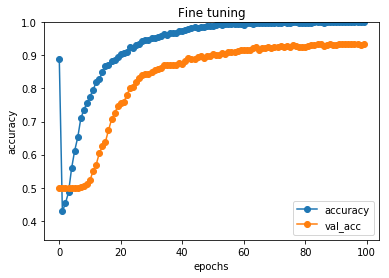

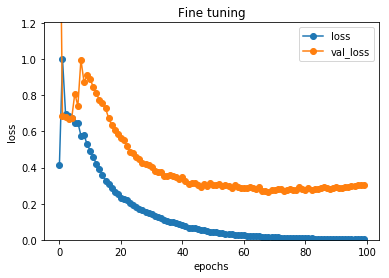

In [50]:
plot_hist(RUN_ID)

---
memo

In [ ]:
os.chdir("/Users/mitsuhiro/Desktop")

In [ ]:
ls 

In [ ]:
os.re4name("%s/cat.14.jpg" % "/Users/mitsuhiro/Desktop" , "%s/cat.14.jpg" % "/Users/mitsuhiro/work") #%の後部分が%sに入る

In [ ]:
# %load utils.py

In [ ]:
!pwd # 

In [ ]:
model.summary()